## The notebook covers Following Topics
    - Missing Value Analysis
    - Correlation Analysis
    - Top Contributing Features (Through XGBoost)
    - Correlation Analysis 
    - Multicollinearity Analysis
    - Univariate Analysis 
    - Bivariate Analysis

## Global Imports ##

In [2]:
import pylab
import calendar
import numpy as np
import pandas as pd
import seaborn as sn
from scipy import stats
import missingno as msno
from datetime import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")
%matplotlib inline

## Reading In Dataset ##

In [3]:
path = 'G:/다른 컴퓨터/My_desktop/project/study/kaggle/data/Zillow Prize Zillow’s Home Value Prediction (Zestimate)'
train = pd.read_csv(path+'/train_2016_v2.csv', parse_dates=["transactiondate"])
properties = pd.read_csv(path+'/properties_2016.csv')

## Shape Of The Dataset ##

In [4]:
print ("Shape Of Train: ",train.shape)
print ("Shape Of Properties: ",properties.shape)

Shape Of Train:  (90275, 3)
Shape Of Properties:  (2985217, 58)


## Lets Merge Train And Properties To Facilitate EDA ##

In [5]:
merged = pd.merge(train,properties,on="parcelid",how="left")

## First Few Rows Of Data ##

In [6]:
merged.head(3).transpose()

,0,1,2
parcelid,11016594,14366692,12098116
logerror,0.0276,-0.1684,-0.004
transactiondate,2016-01-01 00:00:00,2016-01-01 00:00:00,2016-01-01 00:00:00
airconditioningtypeid,1.0,NaN,1.0
architecturalstyletypeid,NaN,NaN,NaN
basementsqft,NaN,NaN,NaN
bathroomcnt,2.0,3.5,3.0
bedroomcnt,3.0,4.0,2.0
buildingclasstypeid,NaN,NaN,NaN
buildingqualitytypeid,4.0,NaN,4.0


## Visualizing Datatypes ##

[Text(0.5, 0, 'Variable Type'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Variables Count Across Datatype')]

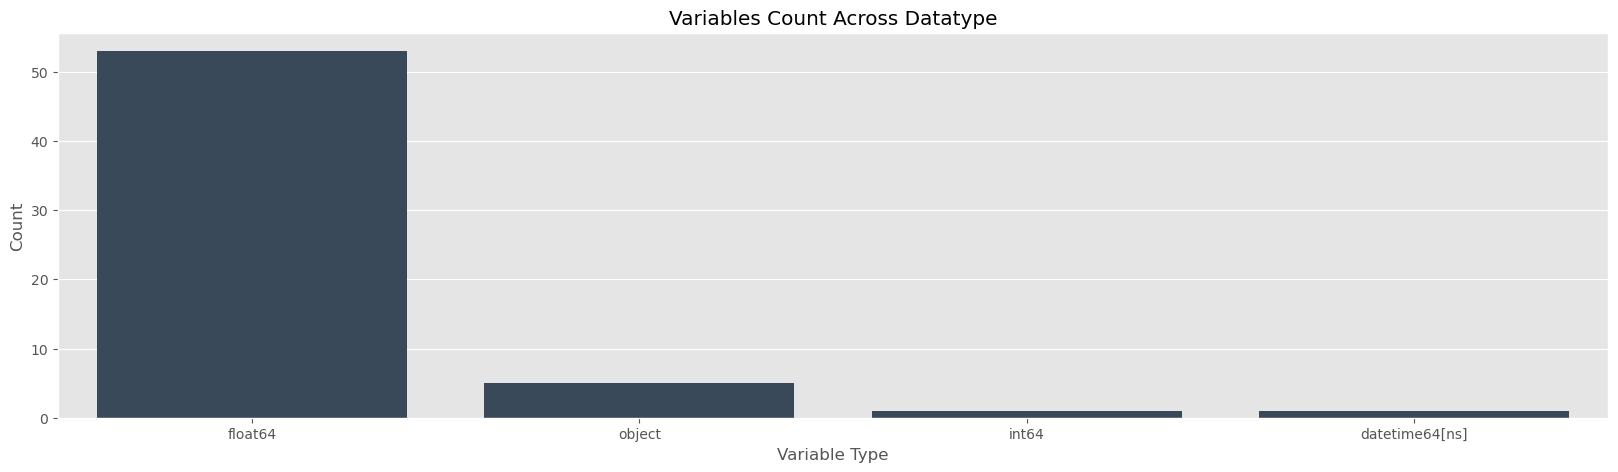

In [7]:
dataTypeDf = pd.DataFrame(merged.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.barplot(data=dataTypeDf,x="variableType",y="count",ax=ax,color="#34495e")
ax.set(xlabel='Variable Type', ylabel='Count',title="Variables Count Across Datatype")

## Missing Value Analysis ##

<AxesSubplot:>

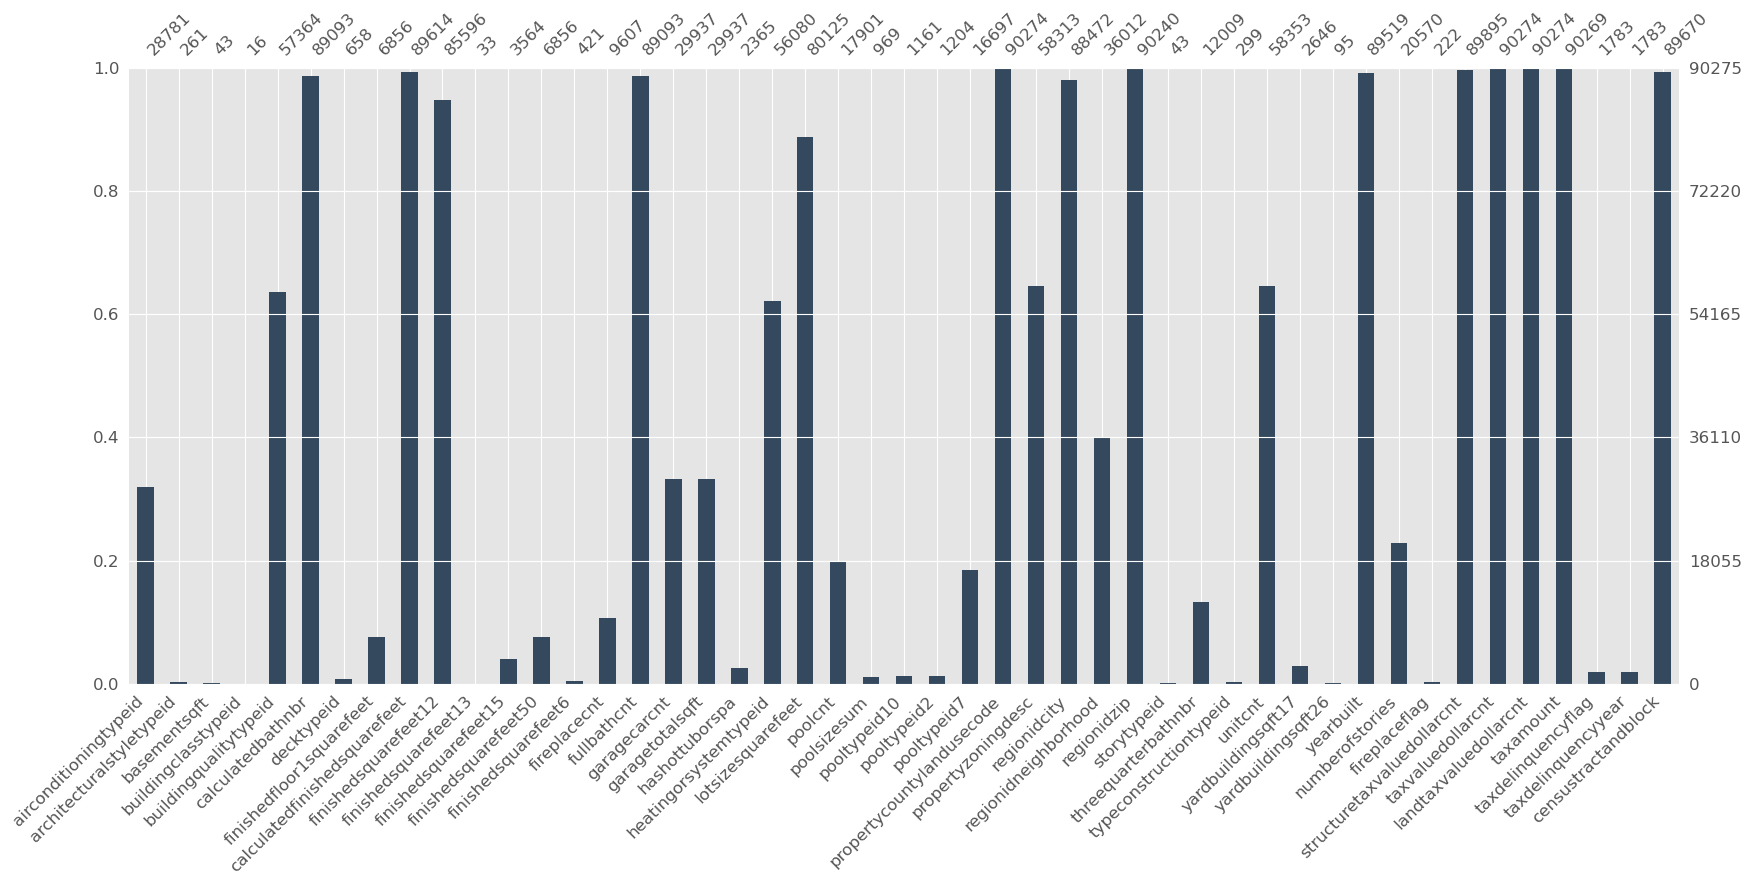

In [8]:
missingValueColumns = merged.columns[merged.isnull().any()].tolist()
msno.bar(merged[missingValueColumns],\
            figsize=(20,8),color="#34495e",fontsize=12,labels=True,)

<AxesSubplot:>

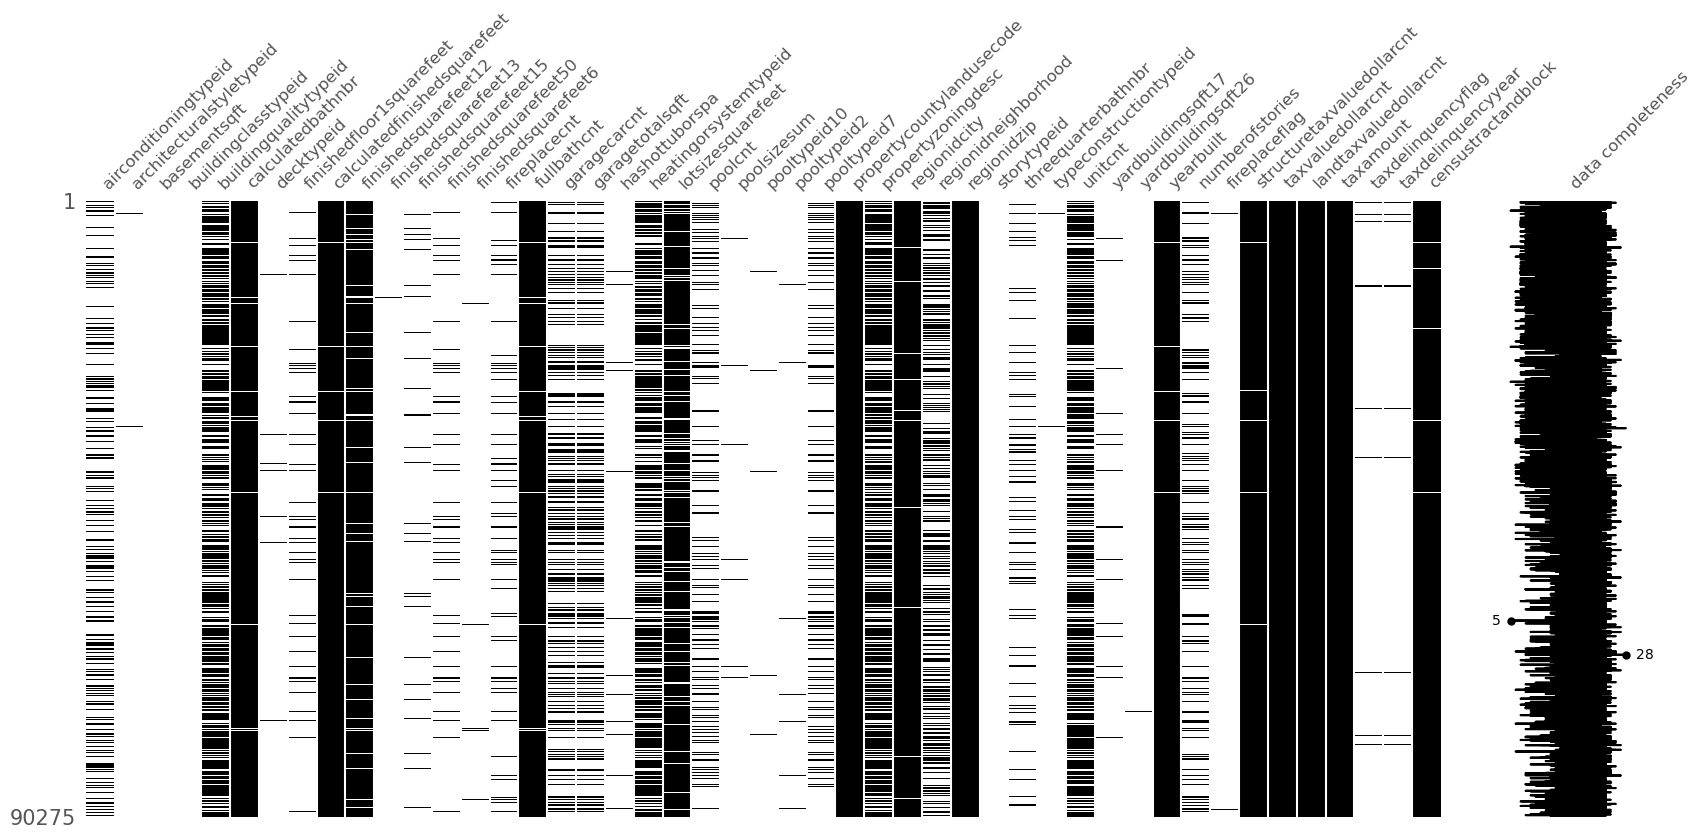

In [9]:
msno.matrix(merged[missingValueColumns],width_ratios=(10,1),\
            figsize=(20,8),color=(0,0, 0),fontsize=12,sparkline=True,labels=True)

<AxesSubplot:>

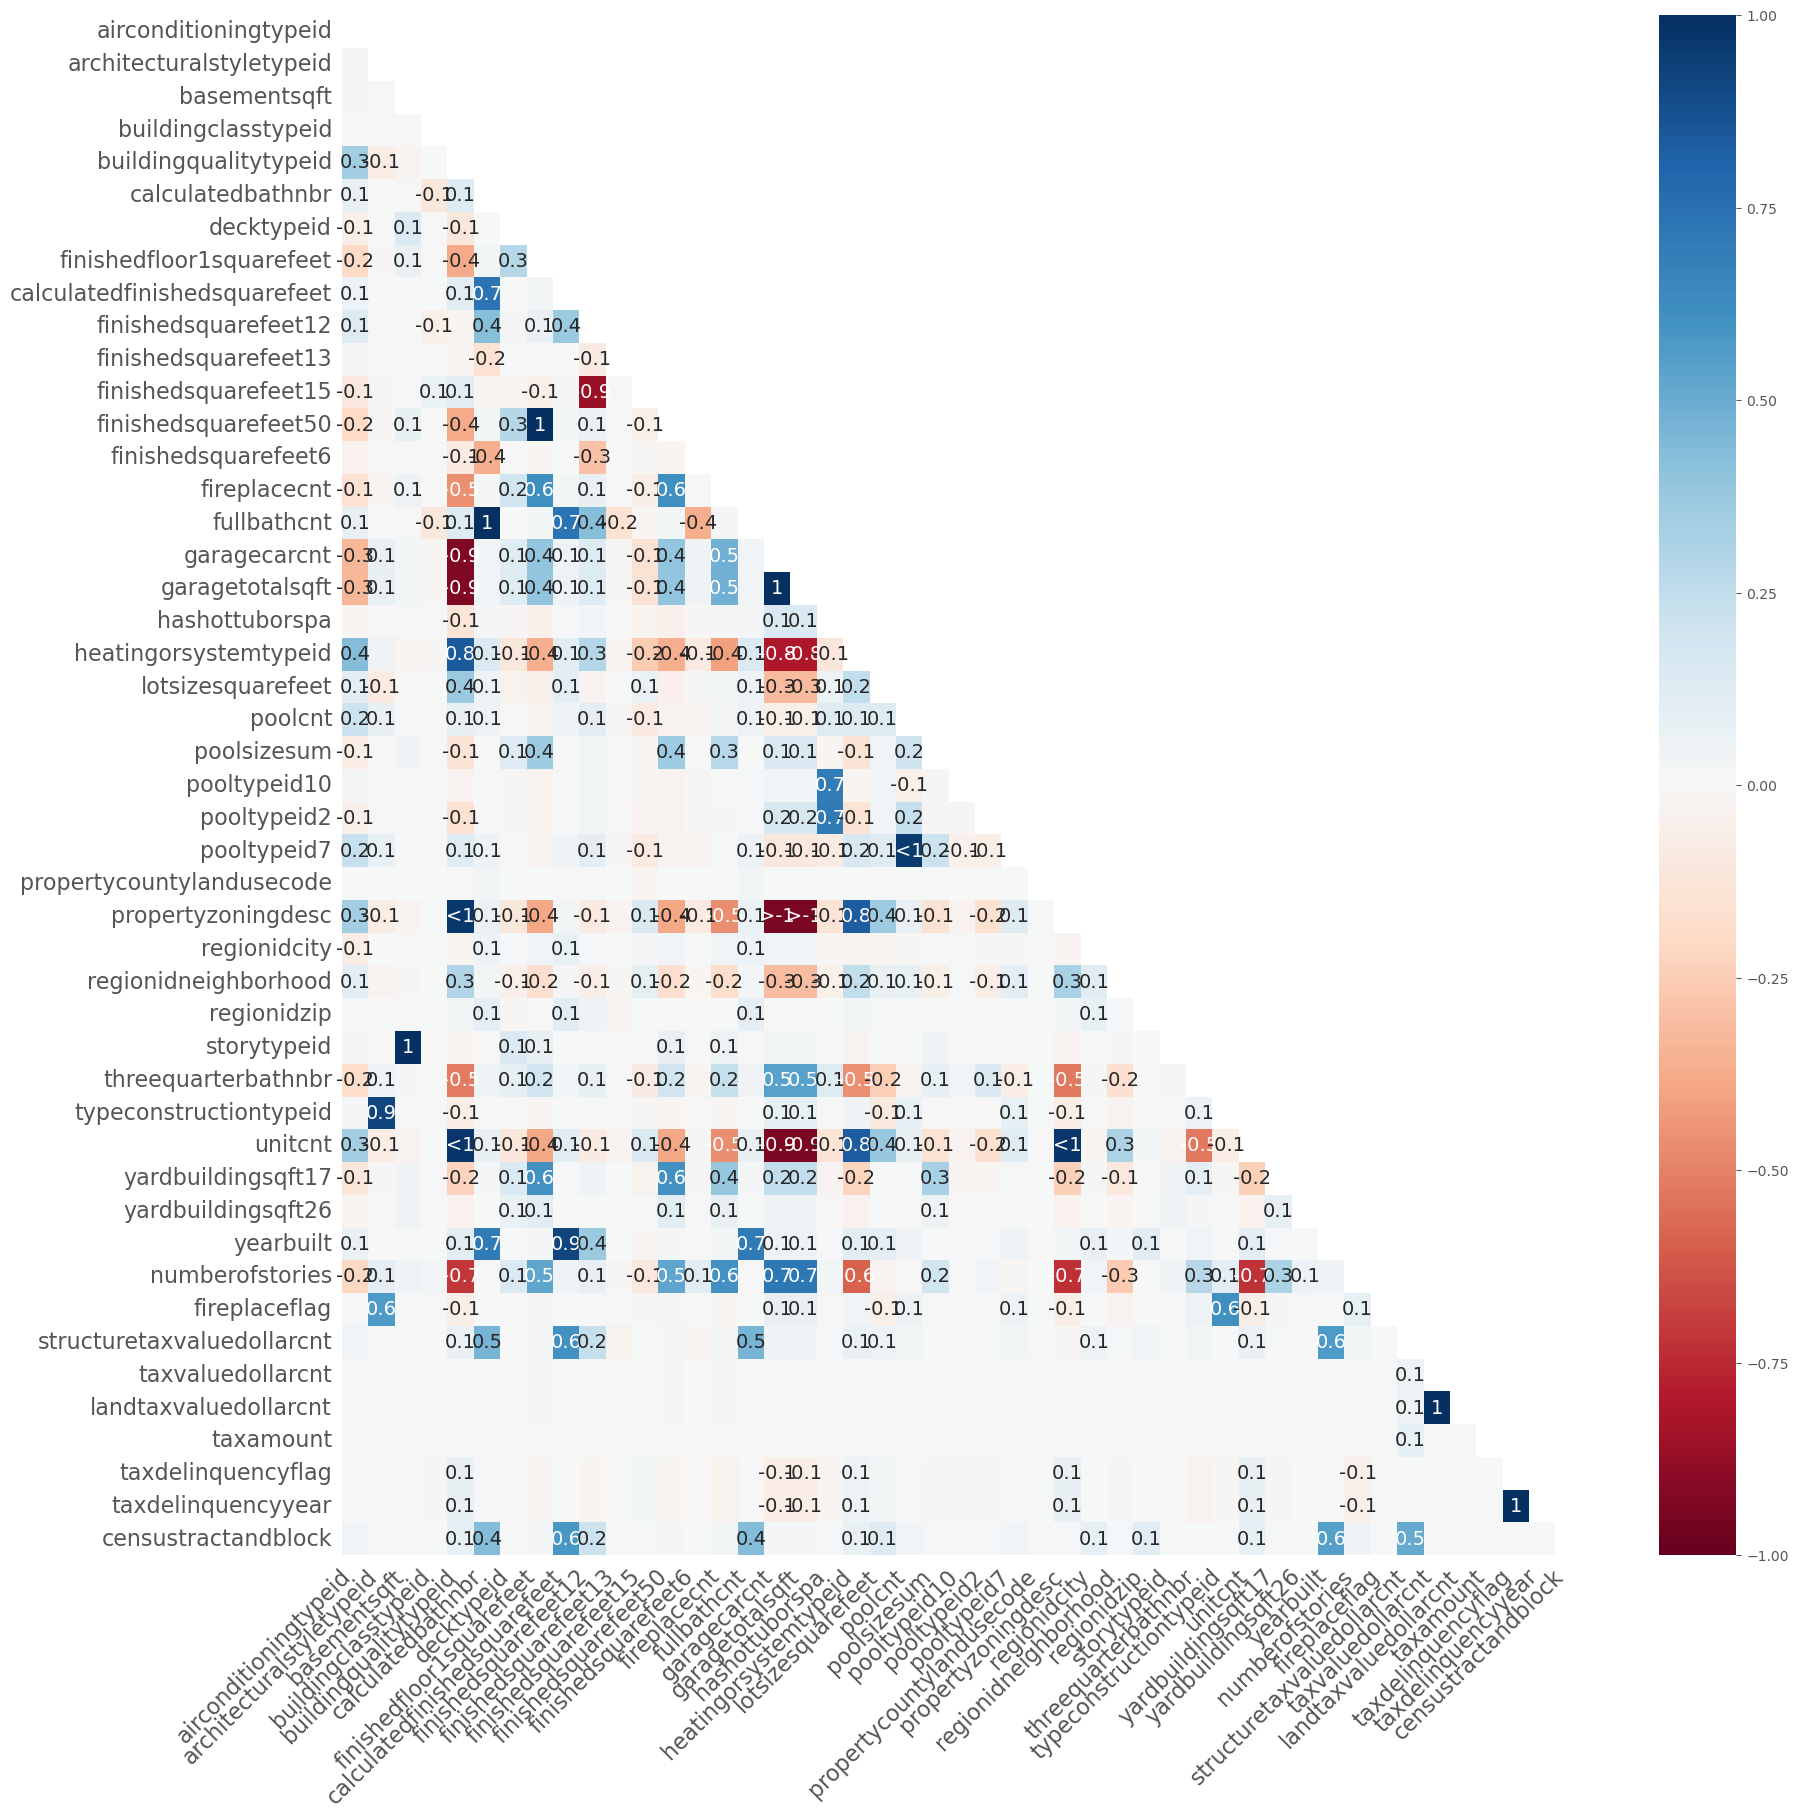

In [10]:
msno.heatmap(merged[missingValueColumns],figsize=(20,20))

## Top Features Selection ##

In [28]:
from sklearn import model_selection, preprocessing
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")

mergedFilterd = merged.fillna(-999)
for f in mergedFilterd.columns:
    if mergedFilterd[f].dtype=='object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(mergedFilterd[f].values)) 
        mergedFilterd[f] = lbl.transform(list(mergedFilterd[f].values))
        
train_y = mergedFilterd.logerror.values
train_X = mergedFilterd.drop(["parcelid", "transactiondate", "logerror"], axis=1)

xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'verbosity': 0
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)

<AxesSubplot:xlabel='importance', ylabel='features'>

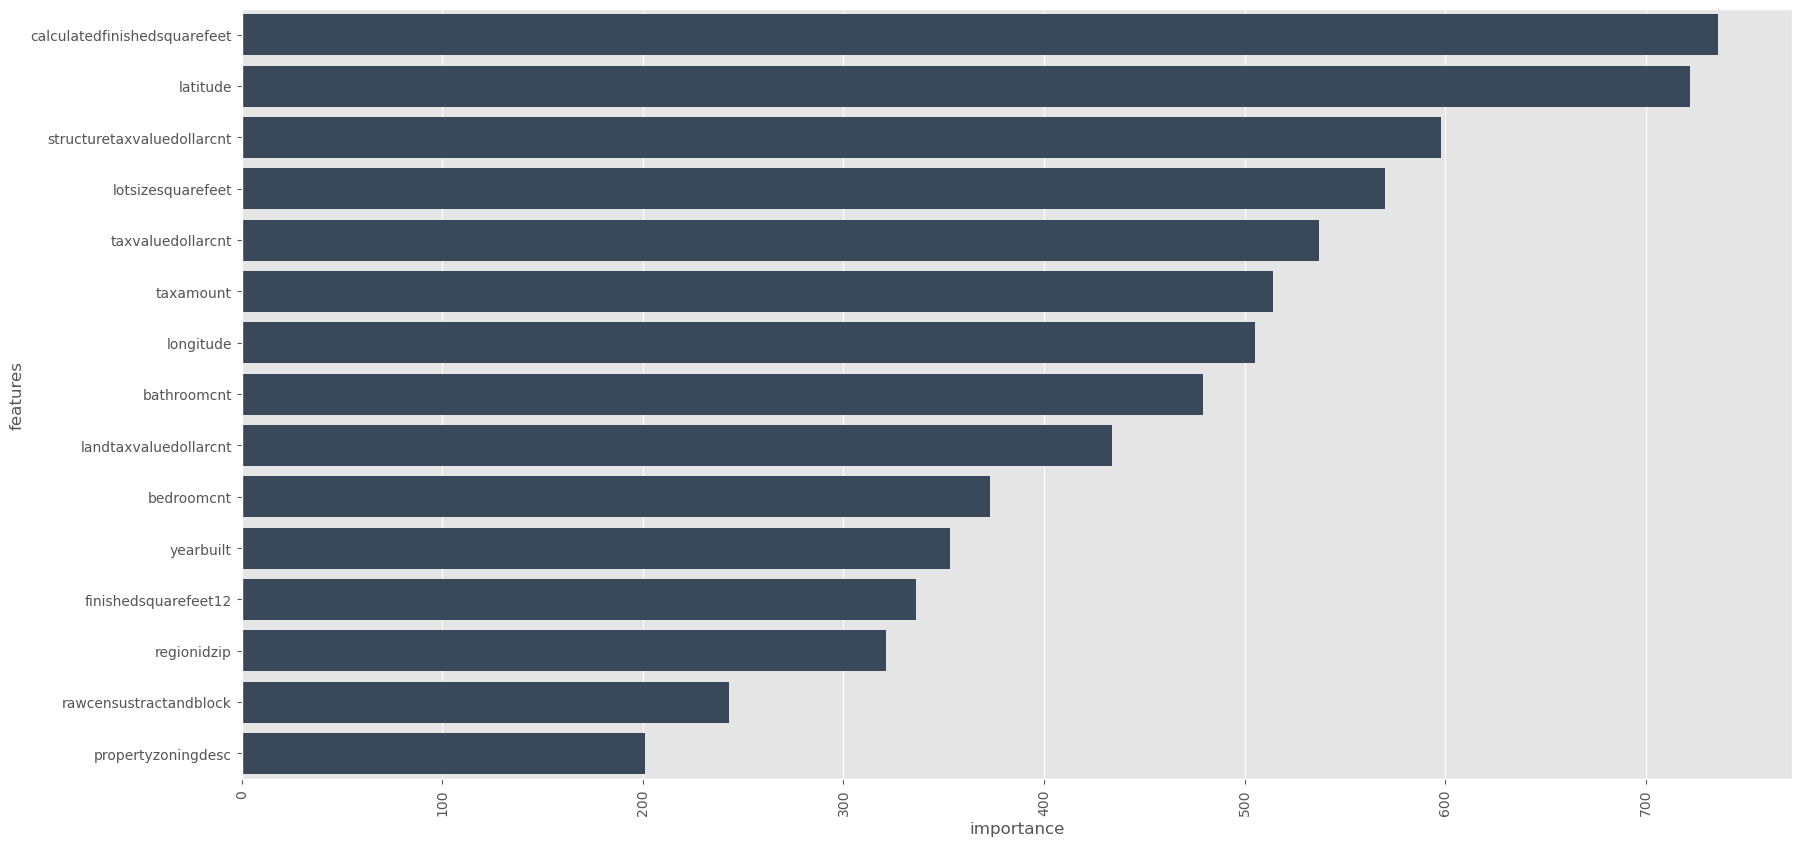

In [12]:
featureImportance = model.get_fscore()
features = pd.DataFrame()
features['features'] = featureImportance.keys()
features['importance'] = featureImportance.values()
features.sort_values(by=['importance'],ascending=False,inplace=True)
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
plt.xticks(rotation=90)
sn.barplot(data=features.head(15),x="importance",y="features",ax=ax,orient="h",color="#34495e")

## Correlation Analysis ##

<AxesSubplot:>

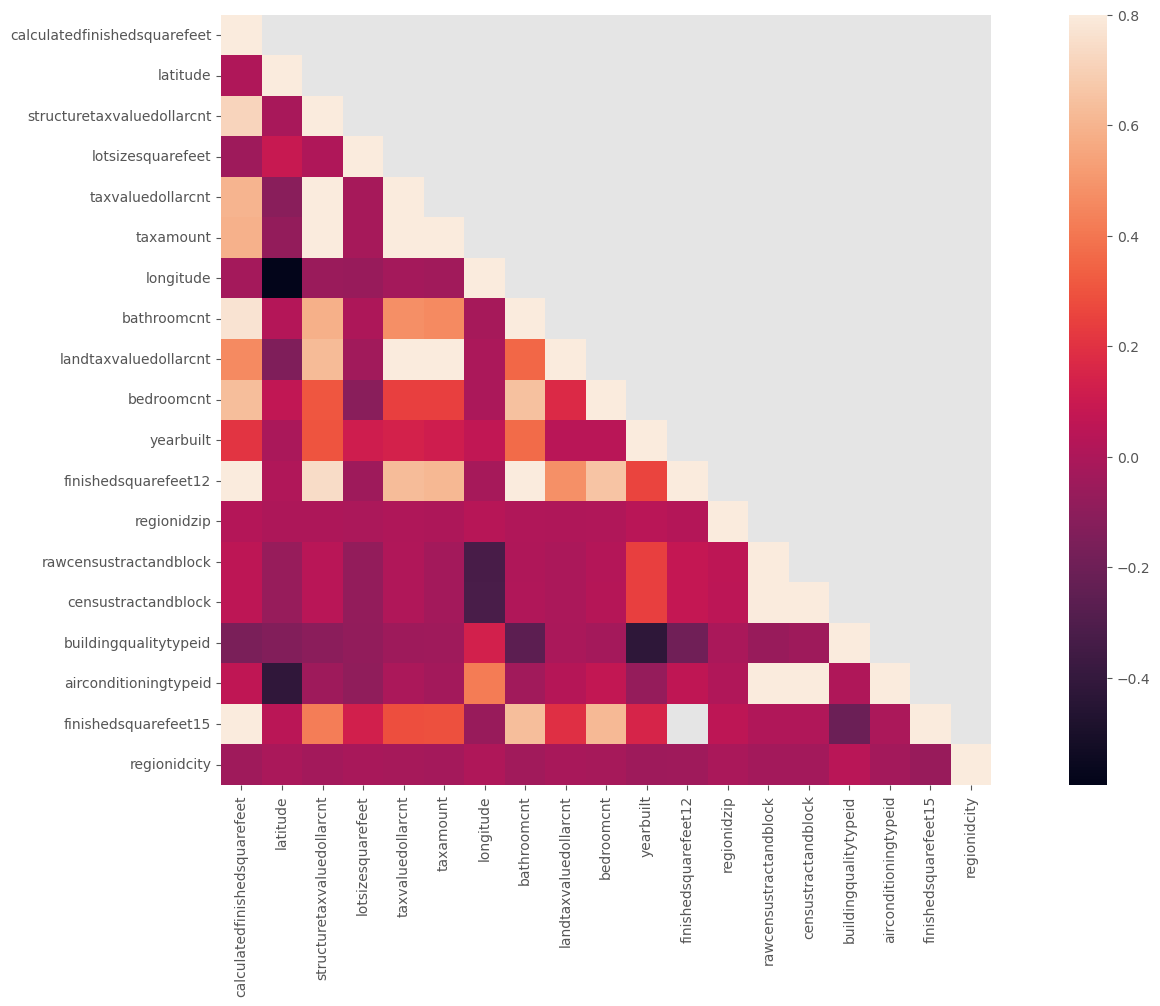

In [13]:
topFeatures = features["features"].tolist()[:20]
corrMatt = merged[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True)

## Multicollinearity Analysis ##

[Text(0.5, 0, 'VIF Scores'),
 Text(0, 0.5, 'Features'),
 Text(0.5, 1.0, 'Variables Which Exhibit Multicollinearity')]

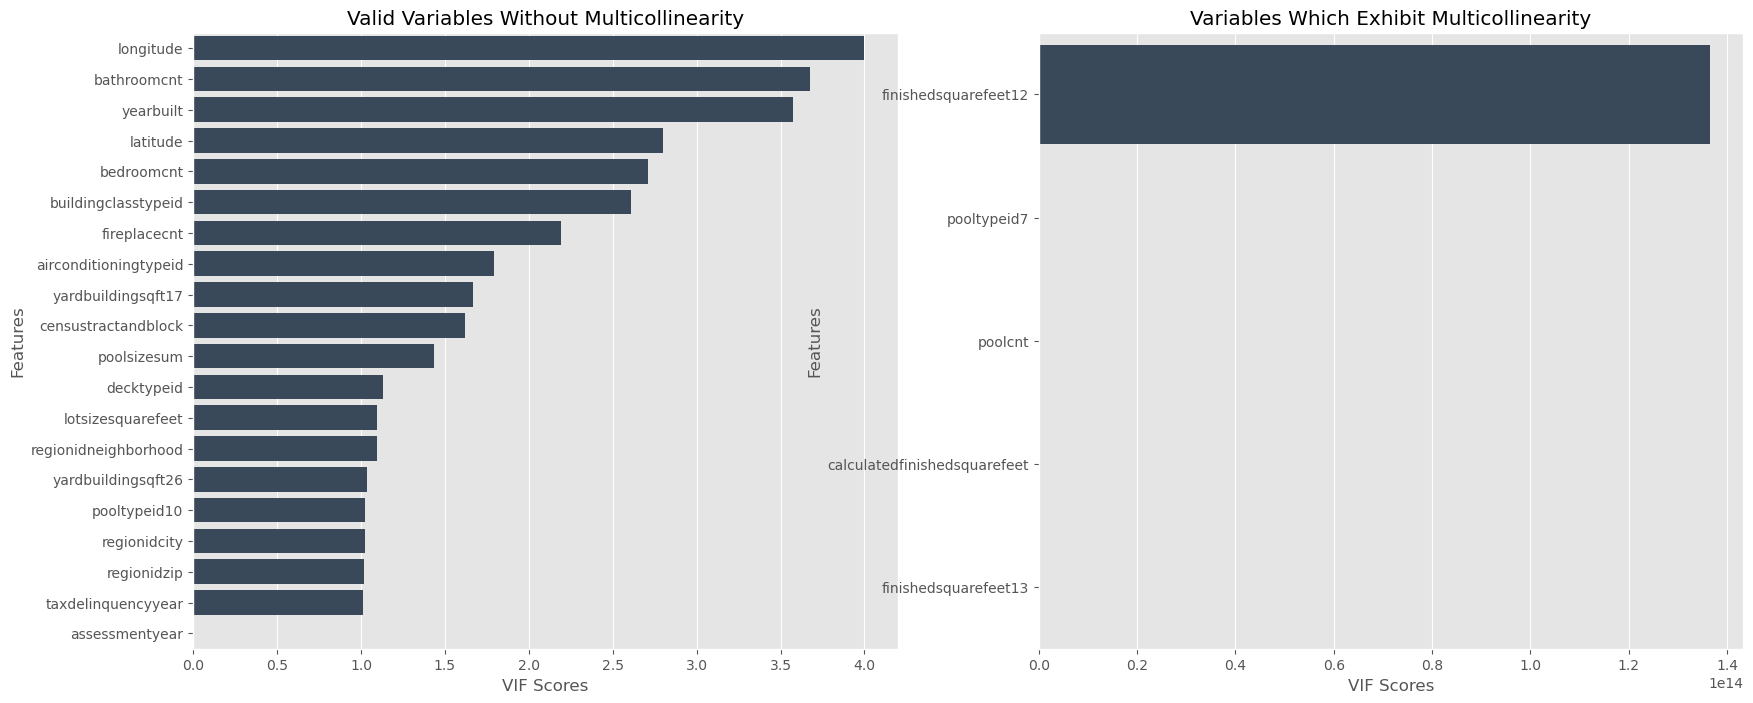

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor  
import warnings
warnings.filterwarnings("ignore")

def calculate_vif_(X):
    variables = list(X.columns)
    vif = {variable:variance_inflation_factor(exog=X.values, exog_idx=ix) for ix,variable in enumerate(list(X.columns))}
    return vif


numericalCol = []
for f in merged.columns:
    #print (f)
    if merged[f].dtype!='object' and f not in ["parcelid", "transactiondate", "logerror"]:
        numericalCol.append(f)
mergedFilterd = merged[numericalCol].fillna(-999)
vifDict = calculate_vif_(mergedFilterd)

vifDf = pd.DataFrame()
vifDf['variables'] = vifDict.keys()
vifDf['vifScore'] = vifDict.values()
vifDf.sort_values(by=['vifScore'],ascending=False,inplace=True)
validVariables = vifDf[vifDf["vifScore"]<=5]
variablesWithMC  = vifDf[vifDf["vifScore"]>5]

fig,(ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(20,8)
sn.barplot(data=validVariables,x="vifScore",y="variables",ax=ax1,orient="h",color="#34495e")
sn.barplot(data=variablesWithMC.head(5),x="vifScore",y="variables",ax=ax2,orient="h",color="#34495e")
ax1.set(xlabel='VIF Scores', ylabel='Features',title="Valid Variables Without Multicollinearity")
ax2.set(xlabel='VIF Scores', ylabel='Features',title="Variables Which Exhibit Multicollinearity")

## Univariate Analysis
** Dependent variable logerror follows nice normal distribution **

[Text(0.5, 0, 'logerror'),
 Text(0, 0.5, 'VIF Score'),
 Text(0.5, 1.0, 'Distribution Of Dependent Variable')]

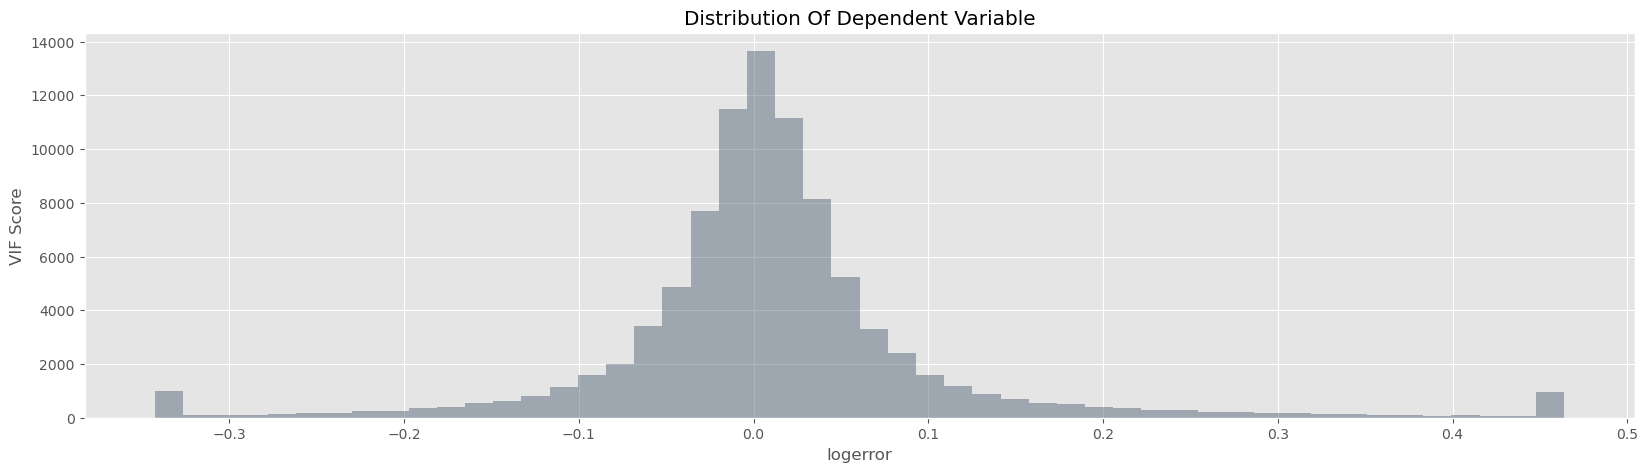

In [15]:
ulimit = np.percentile(merged.logerror.values, 99)
llimit = np.percentile(merged.logerror.values, 1)
# merged['logerror'].ix[merged['logerror']>ulimit] = ulimit
# merged['logerror'].ix[merged['logerror']<llimit] = llimit
merged.loc[merged['logerror'] > ulimit, 'logerror'] = ulimit
merged.loc[merged['logerror'] < llimit, 'logerror'] = llimit


fig,ax = plt.subplots()
fig.set_size_inches(20,5)
sn.distplot(merged.logerror.values, bins=50,kde=False,color="#34495e",ax=ax)
ax.set(xlabel='logerror', ylabel='VIF Score',title="Distribution Of Dependent Variable")

## Bivariate Analysis ##

[Text(0.5, 0, 'Month Of The Year'),
 Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 1.0, 'No Of Occurunces Across Month In 2016'),
 None]

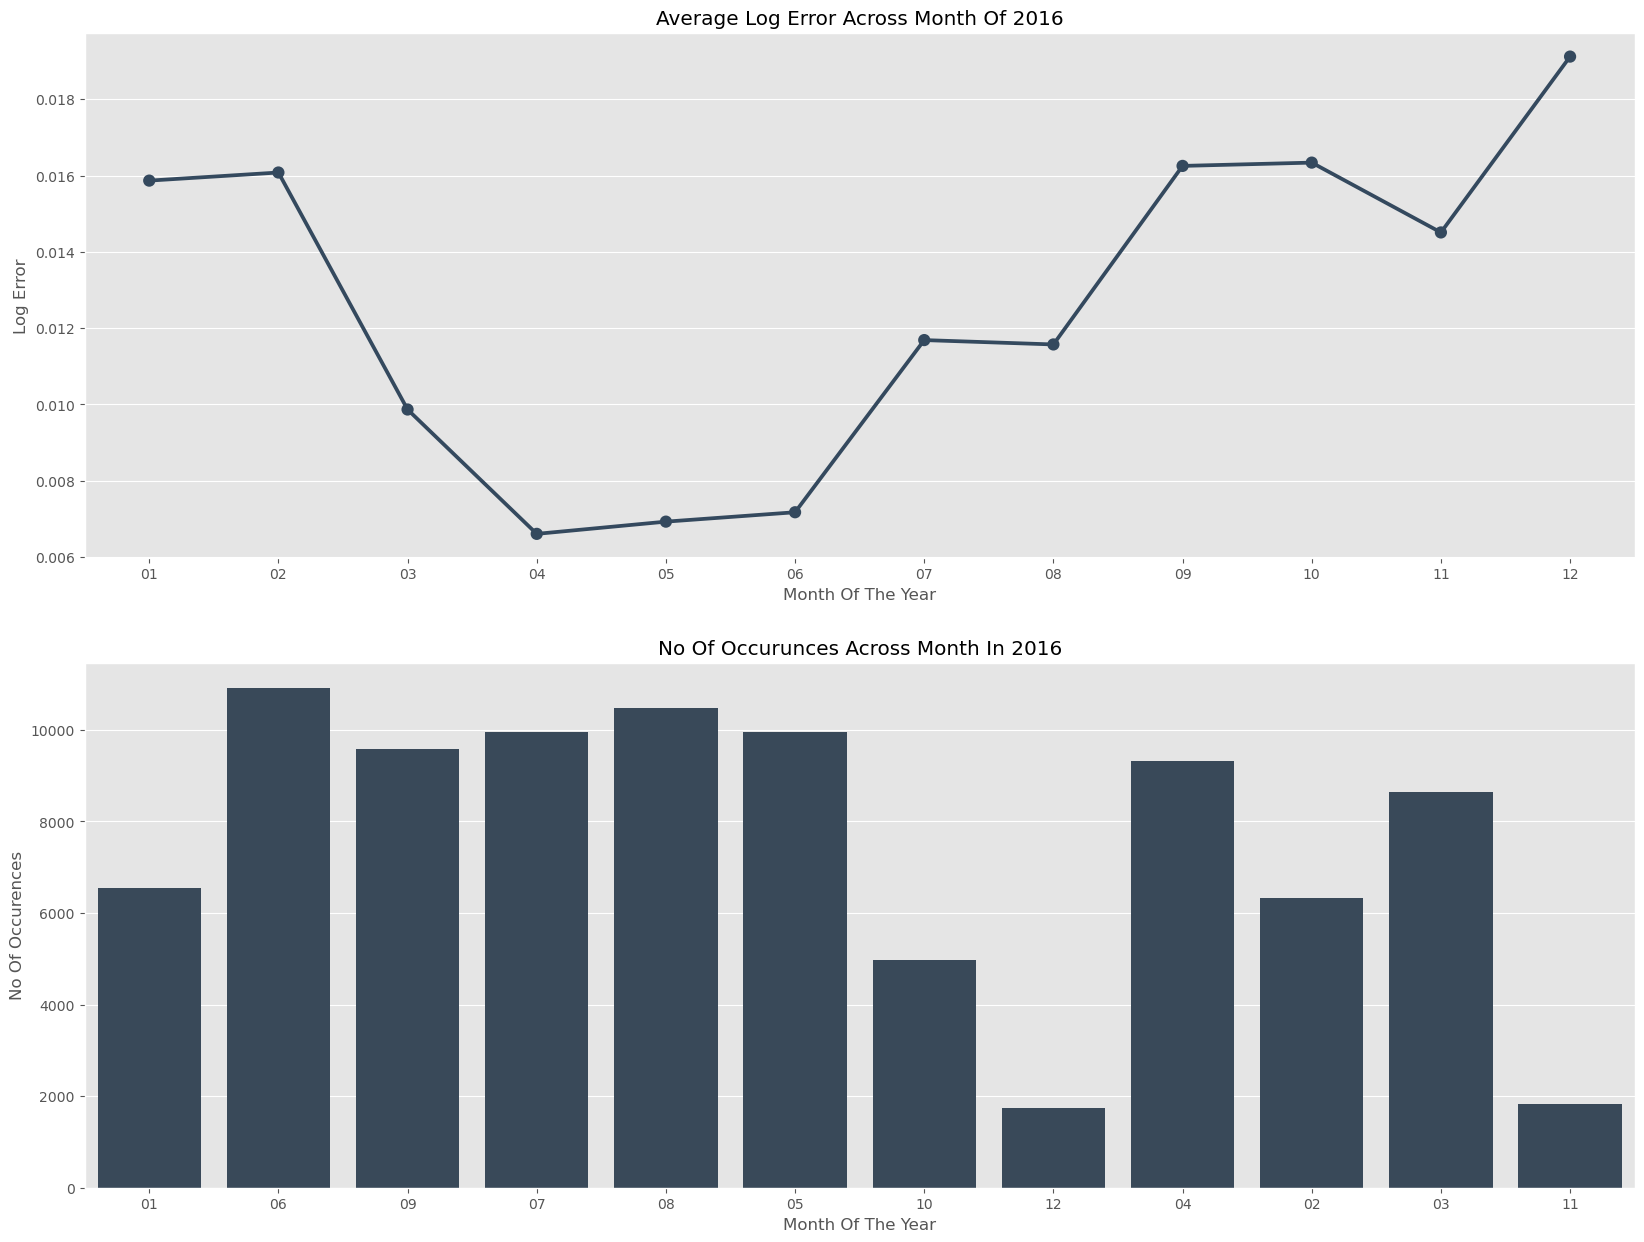

In [16]:
train["year"] = train.transactiondate.map(lambda x: str(x).split("-")[0])
train["month"] = train.transactiondate.map(lambda x: str(x).split("-")[1])
train["day"] = train.transactiondate.map(lambda x: str(x).split("-")[2].split()[0])

traingroupedMonth = train.groupby(["month"])["logerror"].mean().to_frame().reset_index()
traingroupedDay = train.groupby(["day"])["logerror"].mean().to_frame().reset_index()
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)


sn.pointplot(x=traingroupedMonth["month"], y=traingroupedMonth["logerror"], data=traingroupedMonth, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Month Of The Year', ylabel='Log Error',title="Average Log Error Across Month Of 2016",label='big')

sn.countplot(x=train["month"], data=train,ax=ax2,color="#34495e")
ax2.set(xlabel='Month Of The Year', ylabel='No Of Occurences',title="No Of Occurunces Across Month In 2016",label='big')

[Text(0.5, 0, 'Day Of The Month'),
 Text(0, 0.5, 'No Of Occurences'),
 Text(0.5, 1.0, 'No Of Occurences Across Days Of The Month In 2016'),
 None]

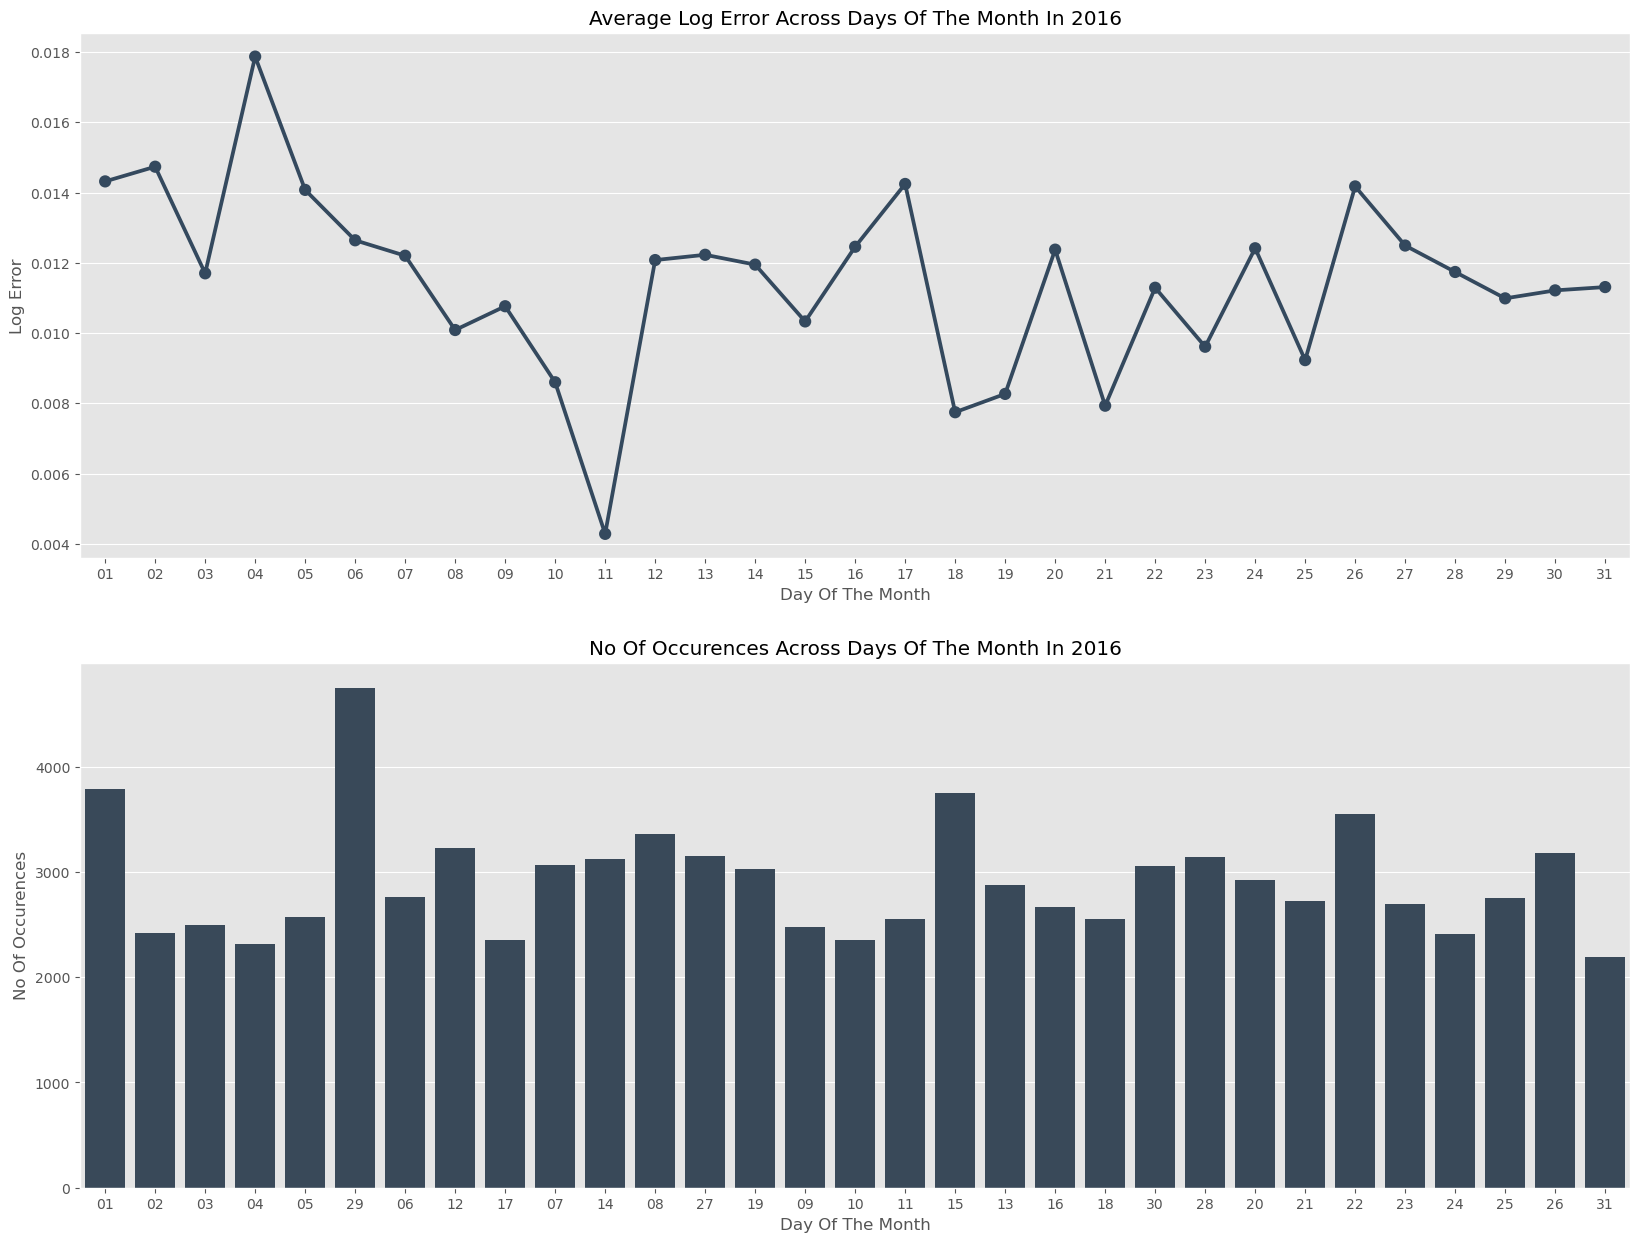

In [17]:
fig,(ax1,ax2)= plt.subplots(nrows=2)
fig.set_size_inches(20,15)

sn.pointplot(x=traingroupedDay["day"], y=traingroupedDay["logerror"], data=traingroupedDay, join=True,ax=ax1,color="#34495e")
ax1.set(xlabel='Day Of The Month', ylabel='Log Error',title="Average Log Error Across Days Of The Month In 2016",label='big')

sn.countplot(x=train["day"], data=train,ax=ax2,color="#34495e")
ax2.set(xlabel='Day Of The Month', ylabel='No Of Occurences',title="No Of Occurences Across Days Of The Month In 2016",label='big')

## No Of Storey Over The Years ##
**It is quite interesting to notice people started building more of 2 or 3 storey buildings After 1950**

<AxesSubplot:xlabel='yearbuilt'>

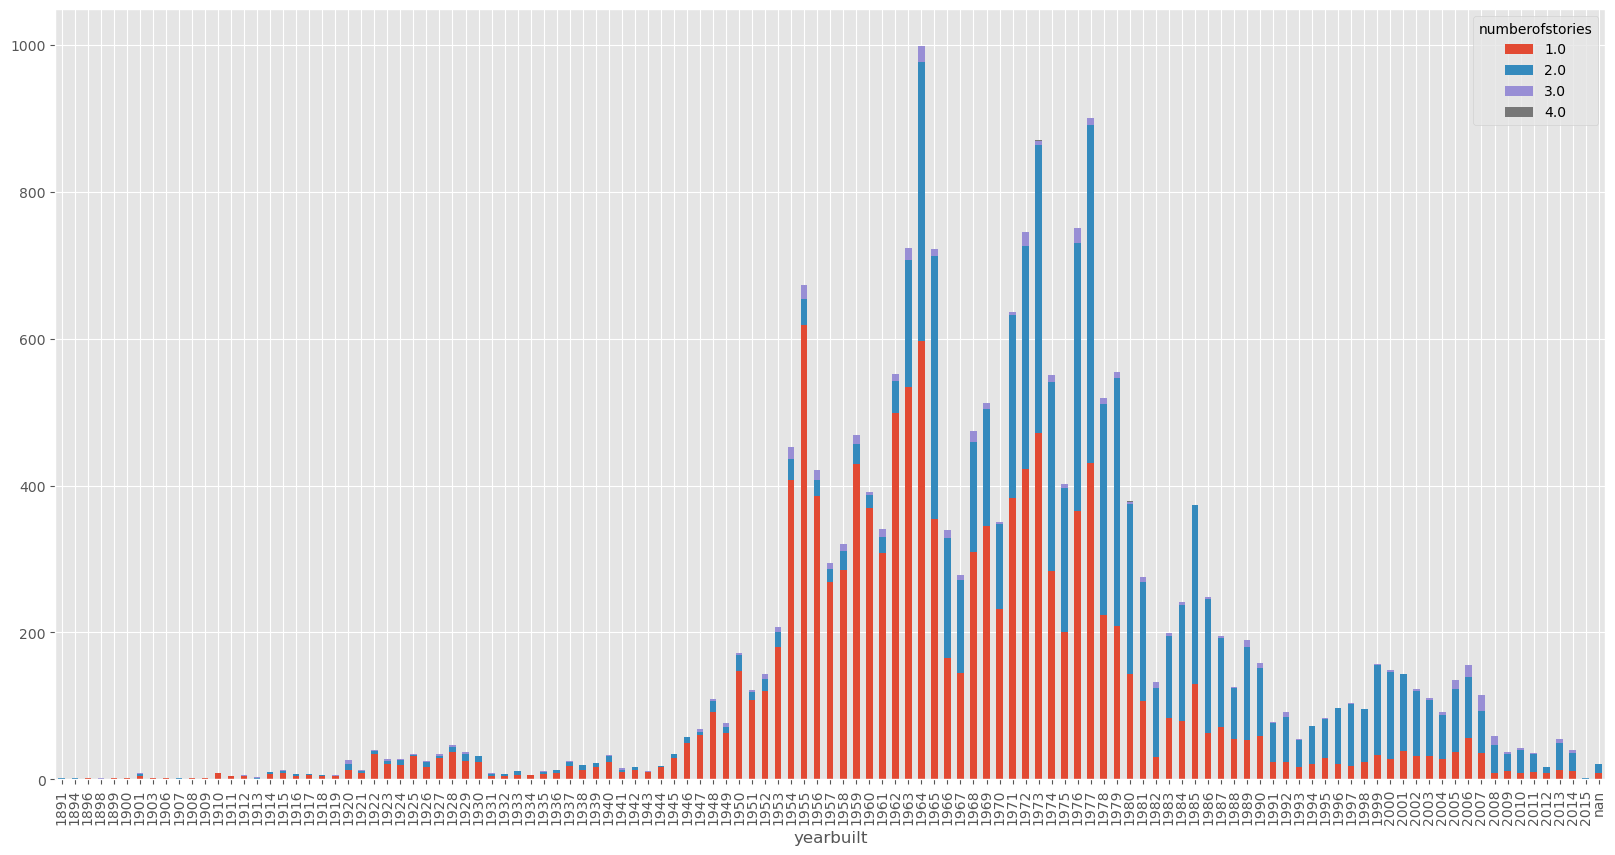

In [18]:
fig,ax1= plt.subplots()
fig.set_size_inches(20,10)
merged["yearbuilt"] = merged["yearbuilt"].map(lambda x:str(x).split(".")[0])
yearMerged = merged.groupby(['yearbuilt', 'numberofstories'])["parcelid"].count().unstack('numberofstories').fillna(0)
yearMerged.plot(kind='bar', stacked=True,ax=ax1)

In [19]:
cols = ["bathroomcnt","bedroomcnt","roomcnt","numberofstories","logerror","calculatedfinishedsquarefeet"]
mergedFiltered = merged[cols].dropna()
for col in cols:
    ulimit = np.percentile(mergedFiltered[col].values, 99.5)
    llimit = np.percentile(mergedFiltered[col].values, 0.5)
    # mergedFiltered[col].ix[mergedFiltered[col]>ulimit] = ulimit
    # mergedFiltered[col].ix[mergedFiltered[col]<llimit] = llimit
    mergedFiltered.loc[mergedFiltered[col]>ulimit, col] = ulimit
    mergedFiltered.loc[mergedFiltered[col]<llimit, col] = llimit


## Calculated Finished Square Feet Vs Log Error ##

<Figure size 1000x800 with 0 Axes>

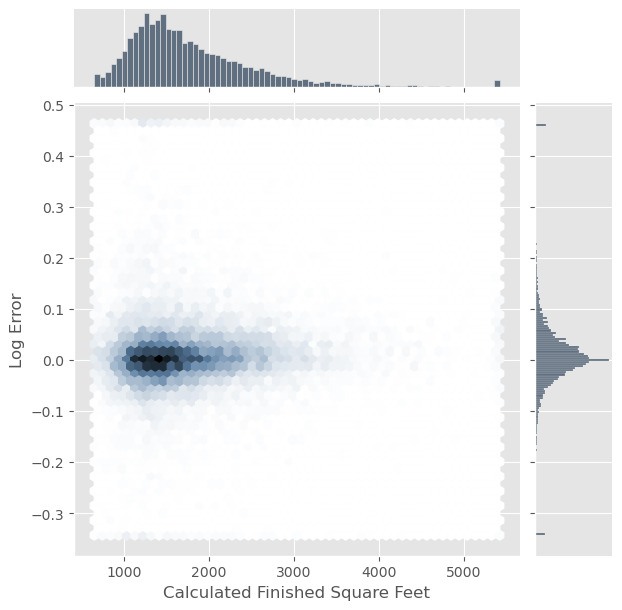

In [20]:
plt.figure(figsize=(10,8))
sn.jointplot(x=mergedFiltered.calculatedfinishedsquarefeet.values, y=mergedFiltered.logerror.values, kind="hex",color="#34495e")
plt.ylabel('Log Error', fontsize=12)
plt.xlabel('Calculated Finished Square Feet', fontsize=12)
plt.show()

## Bedroom Count Vs Log Error ##

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Bedroom Count'),
 Text(0.5, 1.0, 'Bedroom Count Vs Log Error')]

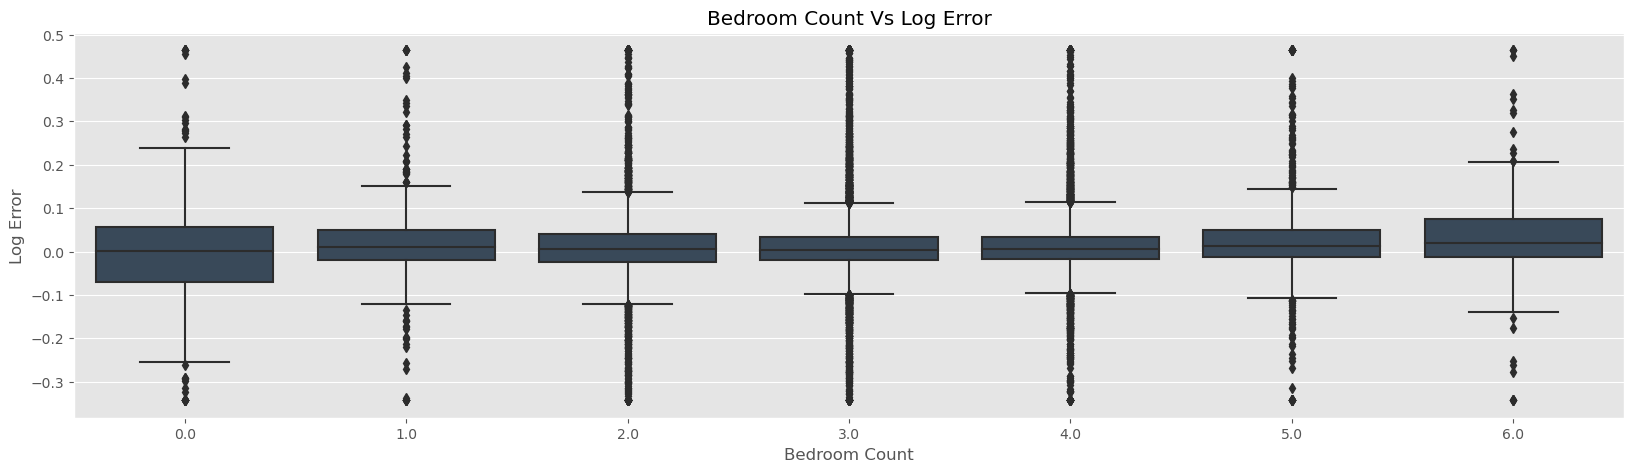

In [21]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.boxplot(x="bedroomcnt", y="logerror", data=mergedFiltered,ax=ax,color="#34495e")
ax.set(ylabel='Log Error',xlabel="Bedroom Count",title="Bedroom Count Vs Log Error")

## Bathroom Count Vs Log Error ##

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Bathroom Count'),
 Text(0.5, 1.0, 'Bathroom Count Vs Log Error')]

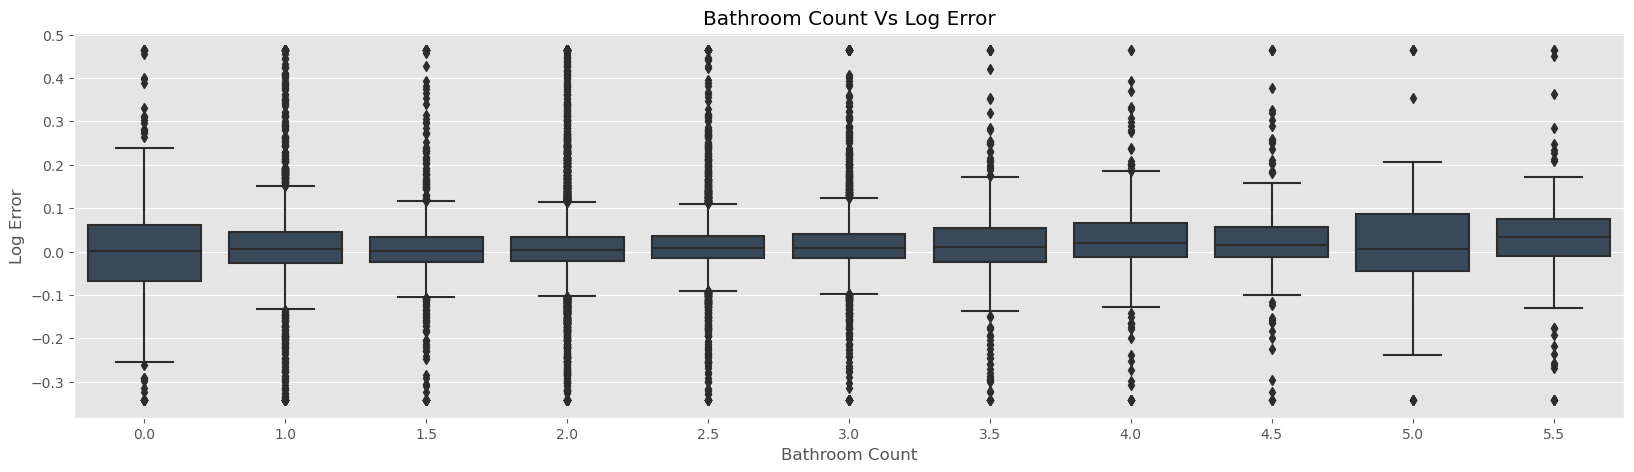

In [22]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.boxplot(x="bathroomcnt", y="logerror", data=mergedFiltered,ax=ax,color="#34495e")
ax.set(ylabel='Log Error',xlabel="Bathroom Count",title="Bathroom Count Vs Log Error")

## Room Count Vs Log Error  ##

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'Room Count'),
 Text(0.5, 1.0, 'Room Count Vs Log Error')]

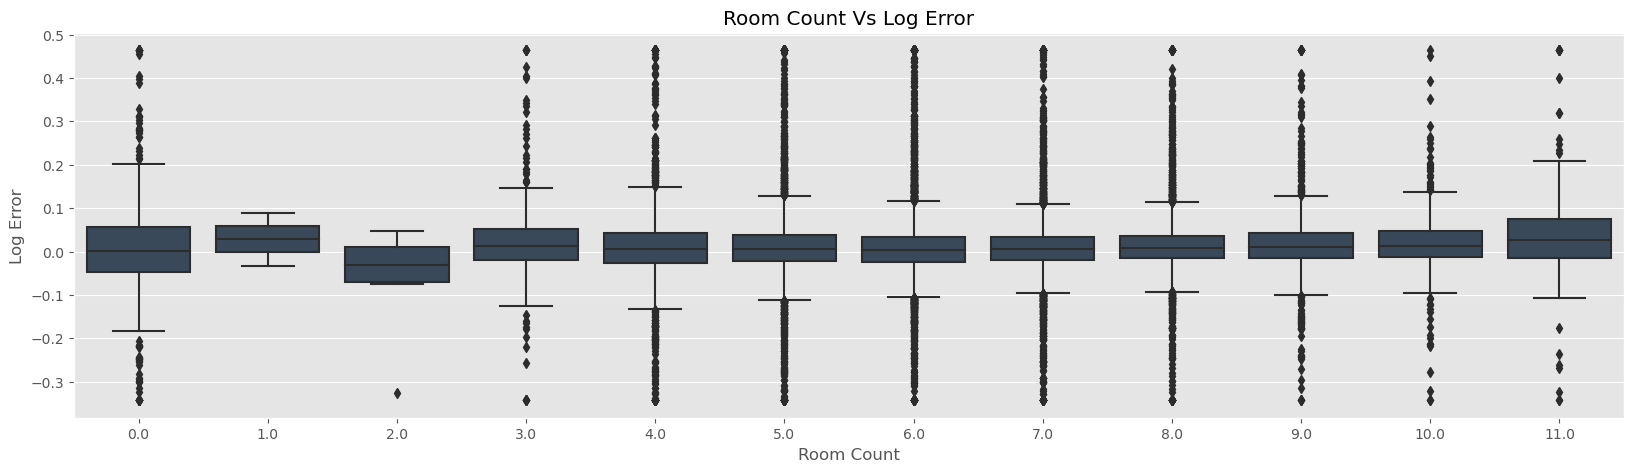

In [23]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.boxplot(x="roomcnt", y="logerror", data=mergedFiltered,ax=ax,color="#34495e")
ax.set(ylabel='Log Error',xlabel="Room Count",title="Room Count Vs Log Error")

## No Of Storeys Vs Log Error ##

[Text(0, 0.5, 'Log Error'),
 Text(0.5, 0, 'No Of Storeys'),
 Text(0.5, 1.0, 'No Of Storeys Vs Log Error')]

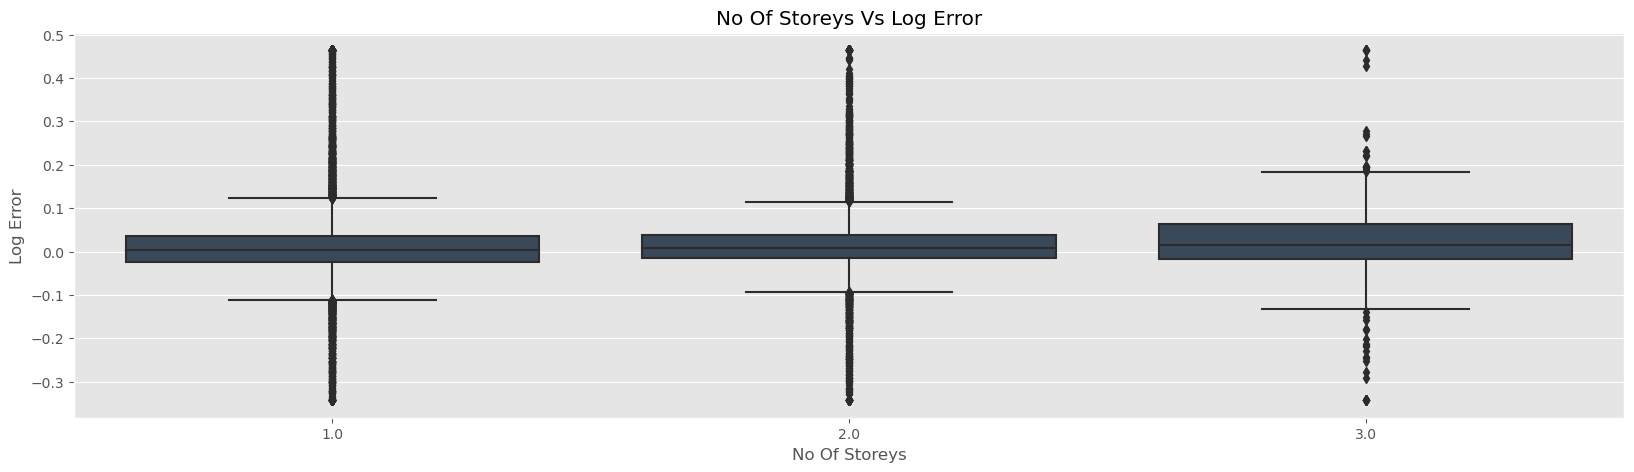

In [24]:
fig,ax= plt.subplots()
fig.set_size_inches(20,5)
sn.boxplot(x="numberofstories", y="logerror", data=mergedFiltered,ax=ax,color="#34495e")
ax.set(ylabel='Log Error',xlabel="No Of Storeys",title="No Of Storeys Vs Log Error")

## Bedroom Vs Bathroom Vs Log Error ##

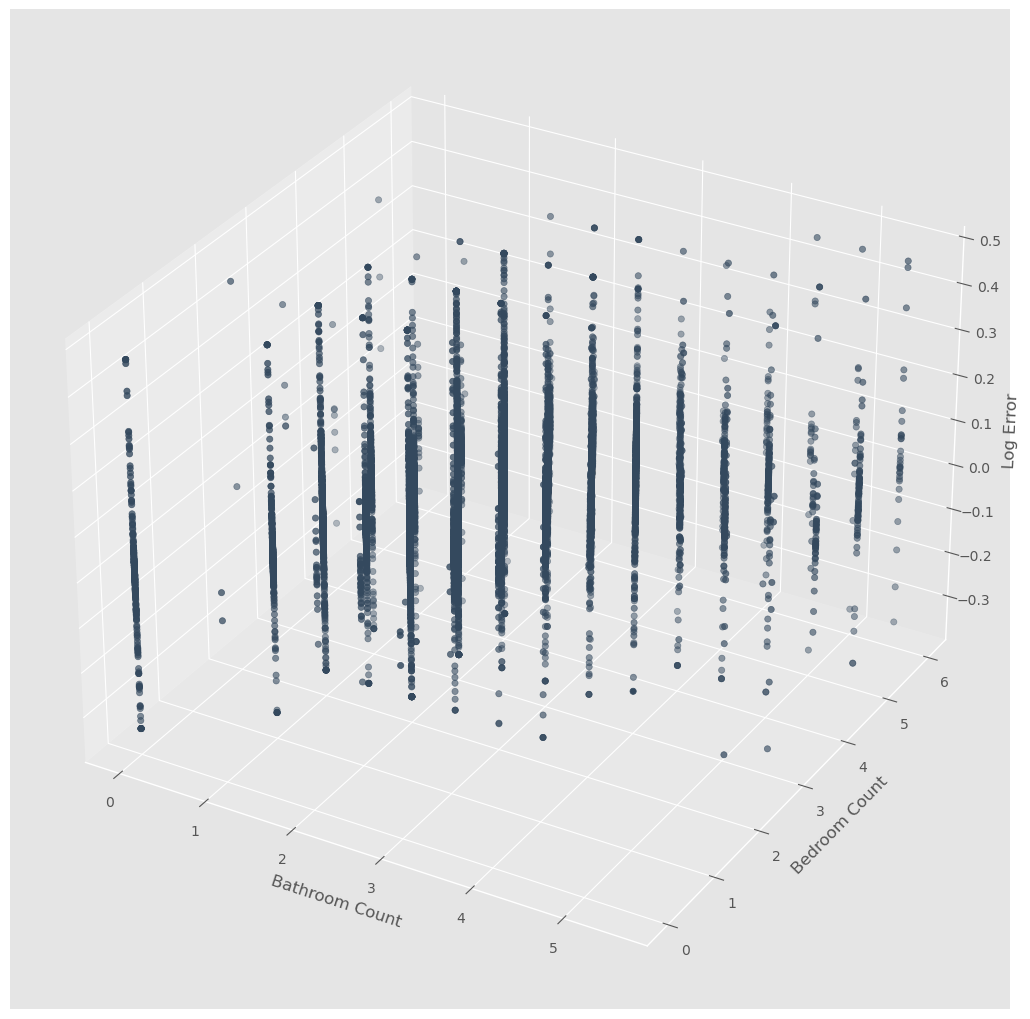

In [25]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot
fig = pylab.figure()
fig.set_size_inches(20,10)
ax = Axes3D(fig)

ax.scatter(mergedFiltered.bathroomcnt, mergedFiltered.bedroomcnt, mergedFiltered.logerror,color="#34495e")
ax.set_xlabel('Bathroom Count')
ax.set_ylabel('Bedroom Count')
ax.set_zlabel('Log Error');
pyplot.show()

**Stay Tuned For More Updates On The Notebook**

**Kindly Upvote If You Find It Useful**